#💵 Proyecto Final: **Scoring Crediticio Inteligente : Prediccion de Riesgo de Default en Creditos**



**Autor:** Gianpierre Trujillo

**Curso:** Data Science II

---

# ***Abstract:***

- El presente proyecto tiene como objetivo analizar y modelar el riesgo de incumplimiento de crédito de los clientes de la institución financiera Home Credit, utilizando un conjunto de datos multi-fuente proveniente de solicitudes actuales y comportamientos crediticios históricos. Este análisis integra variables demográficas, socioeconómicas, historiales de pago e información de solicitudes anteriores y entidades externas, generando así una visión integral del perfil de riesgo del cliente.

- A través de un análisis exploratorio de datos (EDA) exhaustivo, se identificarán patrones relevantes que expliquen la probabilidad de incumplimiento, como la relación deuda/ingresos, pagos atrasados, rechazos previos o la estabilidad laboral. Se aplicarán visualizaciones estadísticas y análisis multivariados para profundizar en las relaciones entre variables y detectar posibles sesgos o inconsistencias.

 Finalmente, este análisis permitirá desarrollar un modelo predictivo de clasificación, el cual podrá ser aplicado por instituciones financieras para anticipar el riesgo de default, optimizar la gestión de portafolios crediticios y facilitar decisiones más sólidas en la evaluación de nuevos clientes.


#***Motivacion:***

- En un entorno financiero cada vez más competitivo y regulado, gestionar adecuadamente el riesgo crediticio es fundamental para preservar la salud financiera de las entidades prestamistas. El creciente volumen de datos, sumado a la complejidad de los perfiles de los clientes, exige soluciones analíticas avanzadas que permitan identificar con anticipación situaciones de incumplimiento y mitigar pérdidas. Este proyecto responde a esa necesidad mediante la construcción de un análisis integral basado en datos multi-fuente, aportando un enfoque sólido y técnico para optimizar los procesos de evaluación crediticia y mejorar la rentabilidad del portafolio.

#***Audiencia:***

- Este análisis está dirigido a responsables de gestión de riesgo, equipos de análisis de crédito, profesionales de inteligencia de negocios y data scientists del sector financiero. Asimismo, puede ser de alto valor para consultores especializados en optimización de portafolios crediticios, así como para decisores estratégicos interesados en implementar modelos predictivos de default que fortalezcan las políticas de concesión de crédito.

#***Preguntas de investigación:***

1. ¿Cuáles son los factores socioeconómicos más relevantes que influyen en el incumplimiento de pagos crediticios?

2. ¿Qué relación existe entre el historial crediticio externo (bureau) y la probabilidad de default en nuevos créditos?

3. ¿En qué medida los rechazos previos de solicitudes afectan la probabilidad de impago actual?

4. ¿Cómo impacta el ratio deuda/ingresos en la capacidad de pago de los clientes?

5. ¿Existen patrones temporales o comportamientos repetitivos en pagos atrasados que ayuden a anticipar la morosidad?

#***Hipótesis:***

- H0: Las variables demográficas, socioeconómicas, y el historial crediticio no presentan un efecto estadísticamente significativo sobre la probabilidad de incumplimiento de crédito en la cartera analizada.
- H1: La proporción de ingresos destinada al pago de deuda (debt-to-income ratio) tiene un efecto positivo significativo sobre la probabilidad de default, incrementando el riesgo a medida que se eleva dicho ratio.

- H2: Los clientes con antecedentes de pagos atrasados recurrentes en sus créditos previos presentan una probabilidad significativamente mayor de incumplimiento en nuevos préstamos, incluso tras controlar otras variables socioeconómicas.

- H3: El número de solicitudes de crédito rechazadas en el pasado se asocia de forma directa con un mayor riesgo de default en solicitudes actuales, actuando como indicador de fragilidad crediticia.

- H4: La estabilidad laboral (definida por la duración del empleo actual) funciona como un factor protector, reduciendo de forma significativa la probabilidad de impago.

- H5: Las variables relacionadas con el historial crediticio externo (por ejemplo, número de préstamos activos y comportamiento de pago reportado en bureau.csv) influyen significativamente en la clasificación de riesgo crediticio del solicitante, mejorando la capacidad de predicción del modelo.

# ***1. Adquisición de Datos (Data Acquisition)***

In [1]:
#Instalamos la api de Kaggle
!pip install -q kaggle

In [2]:
#Importamos las librerias necesarias
import os
import kagglehub
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import mannwhitneyu, chi2_contingency, pointbiserialr
from typing import Tuple, List, Dict

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from typing import Tuple, List, Dict

In [3]:
#Definimos el estilo de los gráficos
sns.set(style="whitegrid")

In [4]:
#Importamos la API Key para Kaggle
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [5]:
#Directorios
COMP = "home-credit-default-risk"
DATA_DIR = "/content/home-credit-default-risk"

In [6]:
#Importamos los archivos y los descomprimimos
!kaggle competitions download -c {COMP} -p /content -q
!unzip -o /content/home-credit-default-risk.zip -d {DATA_DIR} > /dev/null

In [7]:
#Listamos los archivos descargados
download_dir = os.path.join(os.getcwd(), 'home-credit-default-risk')
for root, dirs, files in os.walk(download_dir):
    for file in files:
        print(os.path.join(root, file))

/content/home-credit-default-risk/previous_application.csv
/content/home-credit-default-risk/sample_submission.csv
/content/home-credit-default-risk/credit_card_balance.csv
/content/home-credit-default-risk/application_train.csv
/content/home-credit-default-risk/installments_payments.csv
/content/home-credit-default-risk/bureau.csv
/content/home-credit-default-risk/POS_CASH_balance.csv
/content/home-credit-default-risk/application_test.csv
/content/home-credit-default-risk/HomeCredit_columns_description.csv
/content/home-credit-default-risk/bureau_balance.csv


In [8]:
# Lectura de archivos principales
app_train = pd.read_csv(f"{DATA_DIR}/application_train.csv")
app_test  = pd.read_csv(f"{DATA_DIR}/application_test.csv")
bureau = pd.read_csv(f"{DATA_DIR}/bureau.csv")
bureau_balance = pd.read_csv(f"{DATA_DIR}/bureau_balance.csv")
previous_app = pd.read_csv(f"{DATA_DIR}/previous_application.csv")
pos_cash = pd.read_csv(f"{DATA_DIR}/POS_CASH_balance.csv")
credit_card = pd.read_csv(f"{DATA_DIR}/credit_card_balance.csv")
installments = pd.read_csv(f"{DATA_DIR}/installments_payments.csv")

# Verificamos tamaño
for name, df in {
    "application_train": app_train, "application_test": app_test, "bureau": bureau,
    "bureau_balance": bureau_balance, "previous_application": previous_app,
    "POS_CASH_balance": pos_cash, "credit_card_balance": credit_card,
    "installments_payments": installments
}.items():
    print(f"{name:28s} -> {df.shape}")

application_train            -> (307511, 122)
application_test             -> (48744, 121)
bureau                       -> (1716428, 17)
bureau_balance               -> (27299925, 3)
previous_application         -> (1670214, 37)
POS_CASH_balance             -> (10001358, 8)
credit_card_balance          -> (3840312, 23)
installments_payments        -> (13605401, 8)


####***Diccionario:***

In [9]:
#Usamos el archivo Homecredit_columns_description como diccionario
diccionario = pd.read_csv(f"{DATA_DIR}/HomeCredit_columns_description.csv",
                          encoding='latin-1')
diccionario['Special'] = diccionario['Special'].fillna("")

for table_name, table_df in diccionario.groupby('Table'):
    print(f"Table: {table_name}")
    display(table_df[['Row', 'Description', 'Special']])

Table: POS_CASH_balance.csv


,Row,Description,Special
142,SK_ID_PREV,ID of previous credit in Home Credit related t...,
143,SK_ID_CURR,ID of loan in our sample,
144,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,CNT_INSTALMENT,Term of previous credit (can change over time),
146,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,
147,NAME_CONTRACT_STATUS,Contract status during the month,
148,SK_DPD,DPD (days past due) during the month of previo...,
149,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,


Table: application_{train|test}.csv


,Row,Description,Special
0,SK_ID_CURR,ID of loan in our sample,
1,TARGET,Target variable (1 - client with payment diffi...,
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,
3,CODE_GENDER,Gender of the client,
4,FLAG_OWN_CAR,Flag if the client owns a car,
...,...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,
118,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,
119,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,
120,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,


Table: bureau.csv


,Row,Description,Special
122,SK_ID_CURR,ID of loan in our sample - one loan in our sam...,hashed
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...,hashed
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
126,DAYS_CREDIT,How many days before current application did c...,time only relative to the application
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...,
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...,time only relative to the application
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...,time only relative to the application
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...,
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...,


Table: bureau_balance.csv


,Row,Description,Special
139,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
140,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
141,STATUS,Status of Credit Bureau loan during the month ...,


Table: credit_card_balance.csv


,Row,Description,Special
150,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
151,SK_ID_CURR,ID of loan in our sample,hashed
152,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
153,AMT_BALANCE,Balance during the month of previous credit,
154,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...,
155,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...,
156,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...,
157,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...,
158,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...,
159,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...,


Table: installments_payments.csv


,Row,Description,Special
211,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
212,SK_ID_CURR,ID of loan in our sample,hashed
213,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...,
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment,
215,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,AMT_INSTALMENT,What was the prescribed installment amount of ...,
218,AMT_PAYMENT,What the client actually paid on previous cred...,


Table: previous_application.csv


,Row,Description,Special
173,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
174,SK_ID_CURR,ID of loan in our sample,hashed
175,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",
176,AMT_ANNUITY,Annuity of previous application,
177,AMT_APPLICATION,For how much credit did client ask on the prev...,
178,AMT_CREDIT,Final credit amount on the previous applicatio...,
179,AMT_DOWN_PAYMENT,Down payment on the previous application,
180,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,
181,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...,
182,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...,rounded


#***2. Tratamiento de Datos (Data Wrangling)***

### 2.1 Hacemos un análisis inicial del dataset principal

####2.1.1 Analisis General

In [10]:
#Revisamos las primeras filas
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Vemos un resumen general
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [12]:
#Vemos la distribución de variables numéricas
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [13]:
#Revisamos si hay valores únicos de variables categóricas
for col in app_train.columns:
    if app_train[col].dtype == 'object':
        print(f"{col}: {app_train[col].nunique()} categorias")

NAME_CONTRACT_TYPE: 2 categorias
CODE_GENDER: 3 categorias
FLAG_OWN_CAR: 2 categorias
FLAG_OWN_REALTY: 2 categorias
NAME_TYPE_SUITE: 7 categorias
NAME_INCOME_TYPE: 8 categorias
NAME_EDUCATION_TYPE: 5 categorias
NAME_FAMILY_STATUS: 6 categorias
NAME_HOUSING_TYPE: 6 categorias
OCCUPATION_TYPE: 18 categorias
WEEKDAY_APPR_PROCESS_START: 7 categorias
ORGANIZATION_TYPE: 58 categorias
FONDKAPREMONT_MODE: 4 categorias
HOUSETYPE_MODE: 3 categorias
WALLSMATERIAL_MODE: 7 categorias
EMERGENCYSTATE_MODE: 2 categorias


####2.1.2 Correlaciones entre variables

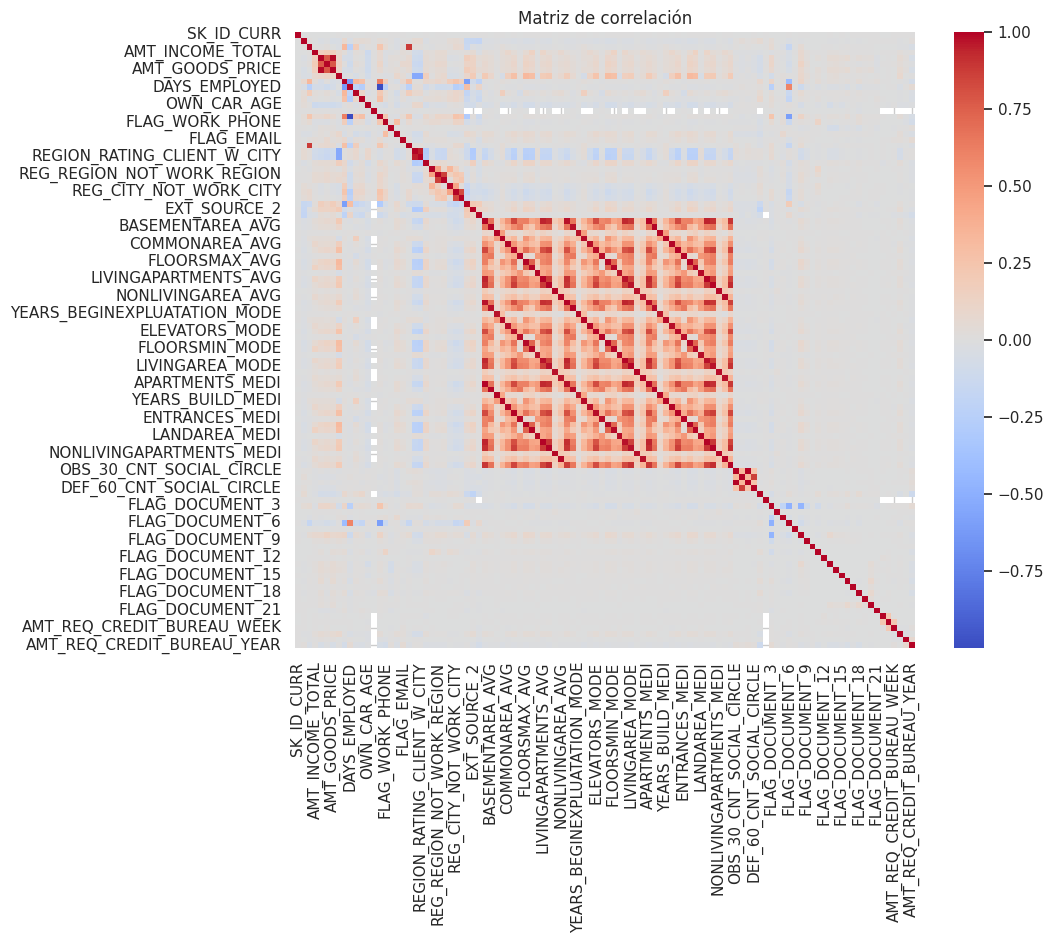

In [14]:
corr = app_train.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de correlación')
plt.show()

####2.1.3 Valores nulos

In [15]:
#Revisión de valores nulos
missing_values = app_train.isnull().sum()
missing_percent = (missing_values / len(app_train)) * 100
missing_df = pd.DataFrame({'Nulos': missing_values, 'Porcentaje (%)': missing_percent}).sort_values(by='Porcentaje (%)', ascending=False)

In [16]:
#Listamos las columnas con valores nulos de mayor a menor a partir del 30%
print ("Variables con mas del 30% de nulos:")
print(missing_df[missing_df['Porcentaje (%)'] > 30])

Variables con mas del 30% de nulos:
                               Nulos  Porcentaje (%)
COMMONAREA_AVG                214865       69.872297
COMMONAREA_MODE               214865       69.872297
COMMONAREA_MEDI               214865       69.872297
NONLIVINGAPARTMENTS_MEDI      213514       69.432963
NONLIVINGAPARTMENTS_MODE      213514       69.432963
NONLIVINGAPARTMENTS_AVG       213514       69.432963
FONDKAPREMONT_MODE            210295       68.386172
LIVINGAPARTMENTS_AVG          210199       68.354953
LIVINGAPARTMENTS_MEDI         210199       68.354953
LIVINGAPARTMENTS_MODE         210199       68.354953
FLOORSMIN_MODE                208642       67.848630
FLOORSMIN_AVG                 208642       67.848630
FLOORSMIN_MEDI                208642       67.848630
YEARS_BUILD_AVG               204488       66.497784
YEARS_BUILD_MODE              204488       66.497784
YEARS_BUILD_MEDI              204488       66.497784
OWN_CAR_AGE                   202929       65.990810
LANDAREA_M

####2.1.4 Imputaciones

| Variable             | % Nulos | Acción tomada                           | Justificación |
|----------------------|---------|-----------------------------------------|---------------|
| `OWN_CAR_AGE`        | ~65%    | Imputada condicionalmente               | Se conserva por relevancia. Si no tiene auto (`FLAG_OWN_CAR = N`), se asigna `0` (*no aplica*). Si tiene auto y falta, se imputó la mediana entre dueños. Además, se creó un flag `OWN_CAR_AGE__imputed_flag` para marcar imputación. |
| `DAYS_EMPLOYED`      | ~5% (con sentinel `365243`) | Se reemplazó `365243` por `NaN` y luego se imputó con mediana. | `365243` es un valor de *missing codificado*. Imputar con mediana conserva coherencia temporal y evita sesgos extremos. |
| Variables categóricas (ej. `OCCUPATION_TYPE`) | 30–40% | Imputadas con categoría `"Missing"` | Evita eliminar columnas con potencial informativo y permite que el modelo detecte patrones asociados a la ausencia de datos. |
| Otras numéricas (>60% nulos, no protegidas) | >60% | Eliminadas | Por alta proporción de nulos, su aporte predictivo es bajo y el riesgo de ruido es alto. |
| Resto de numéricas con nulos moderados | <60% | Imputadas con mediana | La mediana es robusta a outliers y mantiene la distribución central. |
| Resto de categóricas con nulos moderados | <60% | Imputadas con `"Missing"` | Consistente con estrategia global de categorías. |

---

**Resumen**:  
- Se aplicó una regla general de **drop si >60% de nulos**, salvo variables protegidas (`OWN_CAR_AGE`).  
- Se añadieron **flags de imputación** para que el modelo pueda capturar el efecto de los datos faltantes.  
- La estrategia combina criterios técnicos (porcentaje de nulos, tipo de variable) con criterios de negocio (relevancia de la variable en el riesgo crediticio).

#### Nota de justificación: imputación de `OWN_CAR_AGE`

- `OWN_CAR_AGE` tiene >60% de valores nulos. En lugar de eliminar la variable, se decidió **conservarla e imputarla condicionalmente** porque:
  - Es **relevante para el perfil crediticio**: la antigüedad del auto puede reflejar estabilidad económica.
  - El valor “faltante” en muchos casos corresponde a clientes que **no poseen auto**. Para ellos se imputó `0`, interpretado como *no aplica*.
  - En clientes con auto (`FLAG_OWN_CAR = Y`), cuando falta `OWN_CAR_AGE` se imputó la **mediana entre dueños**, lo que mantiene consistencia y evita sesgo extremo.
- Se agregó además un **flag de imputación (`OWN_CAR_AGE__imputed_flag`)** para permitir que el modelo aprenda si la variable fue estimada o estaba disponible.

- Esta estrategia evita perder una variable potencialmente predictiva, mantiene coherencia de negocio y documenta el origen de los datos faltantes.


####2.1.5 Tratamos los nulos

In [17]:
#Modificamos app_train
df = app_train.copy()
if 'DAYS_EMPLOYED' in df.columns:
    df.loc[df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan  # tratamos como missing

#Tabla de nulos y tipos (para documentar)
null_pct = df.isna().mean().sort_values(ascending=False).rename('missing_pct')
dtypes = df.dtypes.astype(str).rename('dtype')
plan_nulos = pd.concat([null_pct, dtypes], axis=1)
display(plan_nulos.head(20))

#Dropeamos si >60% nulos (salvo columnas protegidas)
protected_cols = {'OWN_CAR_AGE'}  # esta justificada su imputacion
to_drop = [c for c in plan_nulos.index if plan_nulos.loc[c, 'missing_pct'] > 0.60 and c not in protected_cols]
df.drop(columns=to_drop, inplace=True, errors='ignore')
print(f"Drop por >60% nulos (excluye protegidas): {len(to_drop)}")

#Imputación general + flags
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

#Flags de imputación
for col in num_cols + cat_cols:
    if df[col].isna().any():
        df[col + '__imputed_flag'] = df[col].isna().astype(int)

#Categóricas: 'Missing'
for col in cat_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna('Missing')

#Numéricas: mediana
for col in num_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

print("Imputación general completa (numéricas=mediana, categóricas='Missing').")

#Caso especial OWN_CAR_AGE según FLAG_OWN_CAR
if {'OWN_CAR_AGE', 'FLAG_OWN_CAR'}.issubset(df.columns):
    df['HAS_CAR'] = df['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0}) if df['FLAG_OWN_CAR'].dtype=='O' else df['FLAG_OWN_CAR']
    df['OWN_CAR_AGE__imputed_flag'] = df['OWN_CAR_AGE'].isna().astype(int)
    # Si NO tiene auto: edad del auto = 0 (no aplica)
    df.loc[df['HAS_CAR'] == 0, 'OWN_CAR_AGE'] = 0
    # Si tiene auto: imputar mediana entre dueños
    owner_mask = df['HAS_CAR'] == 1
    if owner_mask.any():
        median_owner_age = df.loc[owner_mask, 'OWN_CAR_AGE'].median(skipna=True)
        df.loc[owner_mask & df['OWN_CAR_AGE'].isna(), 'OWN_CAR_AGE'] = median_owner_age

if 'FLAG_OWN_REALTY' in df.columns:
    df['HAS_PROPERTY'] = df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

#Fechas negativas -> años (sin fugas)
def to_years(s): return (-s) / 365
if 'DAYS_BIRTH' in df.columns: df['AGE_YEARS'] = to_years(df['DAYS_BIRTH'])
if 'DAYS_EMPLOYED' in df.columns: df['EMPLOYMENT_YEARS'] = to_years(df['DAYS_EMPLOYED'])
for c in ['DAYS_REGISTRATION','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE']:
    if c in df.columns: df[c.replace('DAYS_','') + '_YEARS'] = to_years(df[c])

#Ratios seguros (evitar /0 e infinitos)
def safe_div(a, b):
    return np.where((b==0) | (pd.isna(b)), np.nan, a / b)

if {'AMT_CREDIT','AMT_INCOME_TOTAL'}.issubset(df.columns):
    df['CREDIT_INCOME_RATIO']  = safe_div(df['AMT_CREDIT'], df['AMT_INCOME_TOTAL'])
if {'AMT_ANNUITY','AMT_INCOME_TOTAL'}.issubset(df.columns):
    df['ANNUITY_INCOME_RATIO'] = safe_div(df['AMT_ANNUITY'], df['AMT_INCOME_TOTAL'])
if {'AMT_CREDIT','AMT_GOODS_PRICE'}.issubset(df.columns):
    df['CREDIT_GOODS_RATIO']   = safe_div(df['AMT_CREDIT'], df['AMT_GOODS_PRICE'])
if {'AMT_ANNUITY','AMT_CREDIT'}.issubset(df.columns):
    df['ANNUITY_CREDIT_RATIO'] = safe_div(df['AMT_ANNUITY'], df['AMT_CREDIT'])

#Verificación
print(f"Nulos totales remanentes: {df.isna().sum().sum()}")

#Aplicar al flujo
app_train = df.copy()

,missing_pct,dtype
COMMONAREA_AVG,0.698723,float64
COMMONAREA_MODE,0.698723,float64
COMMONAREA_MEDI,0.698723,float64
NONLIVINGAPARTMENTS_MEDI,0.694330,float64
NONLIVINGAPARTMENTS_MODE,0.694330,float64
NONLIVINGAPARTMENTS_AVG,0.694330,float64
FONDKAPREMONT_MODE,0.683862,object
LIVINGAPARTMENTS_AVG,0.683550,float64
LIVINGAPARTMENTS_MEDI,0.683550,float64
LIVINGAPARTMENTS_MODE,0.683550,float64


Drop por >60% nulos (excluye protegidas): 16
Imputación general completa (numéricas=mediana, categóricas='Missing').


/tmp/ipython-input-2664828942.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['HAS_CAR'] = df['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0}) if df['FLAG_OWN_CAR'].dtype=='O' else df['FLAG_OWN_CAR']
/tmp/ipython-input-2664828942.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['HAS_PROPERTY'] = df['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})
/tmp/ipython-input-2664828942.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

Nulos totales remanentes: 0


####2.1.6 Verificamos duplicados

In [18]:
duplicates = df.duplicated().sum()
print(f"➡️  Filas duplicadas encontradas: {duplicates}")

# Eliminamos duplicados si los hubiera (solo por seguridad)
if duplicates > 0:
    df.drop_duplicates(inplace=True)


➡️  Filas duplicadas encontradas: 0


####2.1.7 Verificamos distribución de variable objetivo

In [19]:
app_train['TARGET'].value_counts(normalize=True)

,proportion
TARGET,
0,0.919271
1,0.080729


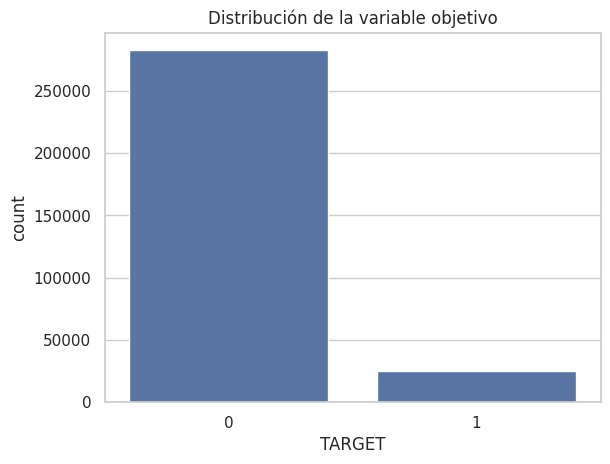

In [20]:
#Graficamos la distribución de la variable objetivo
sns.countplot(x='TARGET', data=app_train)
plt.title('Distribución de la variable objetivo')
plt.show()

- Podemos observar un desbalance de clase, indicando que normalmente hay mas buenos pagadores que malos pagadores.

####2.1.8 Correlaciones con la variable objetivo

In [21]:
target_corr = corr['TARGET'].sort_values(ascending=False) *100
target_corr

,TARGET
TARGET,100.000000
DAYS_BIRTH,7.823931
REGION_RATING_CLIENT_W_CITY,6.089267
REGION_RATING_CLIENT,5.889901
DAYS_LAST_PHONE_CHANGE,5.521848
...,...
FLOORSMAX_AVG,-4.400337
DAYS_EMPLOYED,-4.493166
EXT_SOURCE_1,-15.531713
EXT_SOURCE_2,-16.047167


###2.2 Ahora revisamos los datasets secundarios

####2.2.1 Analisis Exploratorio inicial

In [22]:
ds_secundarios = {"bureau": bureau,
                  "bureau_balance": bureau_balance,
                  "previous_app": previous_app,
                  "pos_cash": pos_cash,
                  "credit_card": credit_card,
                  "installments": installments
}

for name,df in ds_secundarios.items():
  print("="*80)
  print(f"EDA del archivo: {name.upper()}")
  print("="*80)

  print("\nPrimeras filas:")
  display(df.head())

  print("\nInformación general:")
  df.info()

  print("\nDescripción estadística:")
  display(df.describe())

  print("\nValores nulos:")
  nulos = df.isnull().mean().sort_values(ascending=False) * 100
  nulos = nulos[nulos > 0]
  print(nulos)

  print("\nValores Duplicados:")
  duplicates = df.duplicated().sum()
  print(f"Filas duplicadas encontradas: {duplicates}")

  if duplicates > 0:
      app_train.drop_duplicates(inplace=True)

  print("\nVariables categóricas:")
  for col in df.columns:
    if df[col].dtype == 'object':
      print(f"{col}: {df[col].nunique()} categorias")

  print("\n" + "-"*80 + "\n")

EDA del archivo: BUREAU

Primeras filas:


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB

Descripción estadística:


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08



Valores nulos:
AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
DAYS_ENDDATE_FACT         36.916958
AMT_CREDIT_SUM_LIMIT      34.477415
AMT_CREDIT_SUM_DEBT       15.011932
DAYS_CREDIT_ENDDATE        6.149573
AMT_CREDIT_SUM             0.000757
dtype: float64

Valores Duplicados:
Filas duplicadas encontradas: 0

Variables categóricas:
CREDIT_ACTIVE: 4 categorias
CREDIT_CURRENCY: 4 categorias
CREDIT_TYPE: 15 categorias

--------------------------------------------------------------------------------

EDA del archivo: BUREAU_BALANCE

Primeras filas:


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB

Descripción estadística:


,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00



Valores nulos:
Series([], dtype: float64)

Valores Duplicados:
Filas duplicadas encontradas: 0

Variables categóricas:
STATUS: 8 categorias

--------------------------------------------------------------------------------

EDA del archivo: PREVIOUS_APP

Primeras filas:


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT   

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000



Valores nulos:
RATE_INTEREST_PRIVILEGED     99.643698
RATE_INTEREST_PRIMARY        99.643698
AMT_DOWN_PAYMENT             53.636480
RATE_DOWN_PAYMENT            53.636480
NAME_TYPE_SUITE              49.119754
DAYS_TERMINATION             40.298129
DAYS_FIRST_DRAWING           40.298129
DAYS_FIRST_DUE               40.298129
DAYS_LAST_DUE_1ST_VERSION    40.298129
DAYS_LAST_DUE                40.298129
NFLAG_INSURED_ON_APPROVAL    40.298129
AMT_GOODS_PRICE              23.081773
AMT_ANNUITY                  22.286665
CNT_PAYMENT                  22.286366
PRODUCT_COMBINATION           0.020716
AMT_CREDIT                    0.000060
dtype: float64

Valores Duplicados:
Filas duplicadas encontradas: 0

Variables categóricas:
NAME_CONTRACT_TYPE: 4 categorias
WEEKDAY_APPR_PROCESS_START: 7 categorias
FLAG_LAST_APPL_PER_CONTRACT: 2 categorias
NAME_CASH_LOAN_PURPOSE: 25 categorias
NAME_CONTRACT_STATUS: 4 categorias
NAME_PAYMENT_TYPE: 4 categorias
CODE_REJECT_REASON: 9 categorias
NAME_TYPE_SUIT

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB

Descripción estadística:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03



Valores nulos:
CNT_INSTALMENT_FUTURE    0.260835
CNT_INSTALMENT           0.260675
dtype: float64

Valores Duplicados:
Filas duplicadas encontradas: 0

Variables categóricas:
NAME_CONTRACT_STATUS: 9 categorias

--------------------------------------------------------------------------------

EDA del archivo: CREDIT_CARD

Primeras filas:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19 

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03



Valores nulos:
AMT_PAYMENT_CURRENT           19.998063
CNT_DRAWINGS_POS_CURRENT      19.524872
AMT_DRAWINGS_ATM_CURRENT      19.524872
CNT_DRAWINGS_ATM_CURRENT      19.524872
AMT_DRAWINGS_POS_CURRENT      19.524872
AMT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_DRAWINGS_OTHER_CURRENT    19.524872
CNT_INSTALMENT_MATURE_CUM      7.948208
AMT_INST_MIN_REGULARITY        7.948208
dtype: float64

Valores Duplicados:
Filas duplicadas encontradas: 0

Variables categóricas:
NAME_CONTRACT_STATUS: 7 categorias

--------------------------------------------------------------------------------

EDA del archivo: INSTALLMENTS

Primeras filas:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB

Descripción estadística:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06



Valores nulos:
AMT_PAYMENT           0.021352
DAYS_ENTRY_PAYMENT    0.021352
dtype: float64

Valores Duplicados:
Filas duplicadas encontradas: 0

Variables categóricas:

--------------------------------------------------------------------------------



###2.3 Tratamiento de Datos

####2.3.1 Convertimos a Flags en binario

In [23]:
app_train['HAS_CAR'] = app_train['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
app_train['HAS_PROPERTY'] = app_train['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

####2.3.2 Creamos columnas numericas derivadas de fechas negativas

In [24]:
app_train['AGE_YEARS'] = (-app_train['DAYS_BIRTH']) / 365
app_train['EMPLOYMENT_YEARS'] = (-app_train['DAYS_EMPLOYED'].replace(365243, np.nan)) / 365
app_train['REGISTRATION_YEARS'] = (-app_train['DAYS_REGISTRATION']) / 365
app_train['ID_PUBLISH_YEARS'] = (-app_train['DAYS_ID_PUBLISH']) / 365
app_train['PHONE_CHANGE_YEARS'] = (-app_train['DAYS_LAST_PHONE_CHANGE']) / 365

####2.3.3 Creamos algunos ratios financieros base

In [25]:
app_train['CREDIT_INCOME_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_RATIO'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_GOODS_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
app_train['ANNUITY_CREDIT_RATIO'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']

####2.3.4 Verificamos estructura final

In [26]:
print("\n✅ Data wrangling de application_train completado")
print(app_train.shape)
app_train.head(3)


✅ Data wrangling de application_train completado
(307511, 170)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AGE_YEARS,EMPLOYMENT_YEARS,REGISTRATION_YEARS,ID_PUBLISH_YEARS,LAST_PHONE_CHANGE_YEARS,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,CREDIT_GOODS_RATIO,ANNUITY_CREDIT_RATIO,PHONE_CHANGE_YEARS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,25.920548,1.745205,9.994521,5.808219,3.106849,2.007889,0.121978,1.158397,0.060749,3.106849
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,45.931507,3.254795,3.249315,0.797260,2.268493,4.790750,0.132217,1.145199,0.027598,2.268493
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,52.180822,0.616438,11.671233,6.934247,2.232877,2.000000,0.100000,1.000000,0.050000,2.232877


###2.4 Realizamos merge de las tablas secundarias a la principal

####2.4.1 Merge con Bureau

- Preparacion para el merge

In [27]:
print("➡️  Tamaño original:", bureau.shape)
print("➡️  Porcentaje de nulos:")
print(bureau.isnull().mean().sort_values(ascending=False).head(10))

➡️  Tamaño original: (1716428, 17)
➡️  Porcentaje de nulos:
AMT_ANNUITY               0.714735
AMT_CREDIT_MAX_OVERDUE    0.655133
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_SUM_LIMIT      0.344774
AMT_CREDIT_SUM_DEBT       0.150119
DAYS_CREDIT_ENDDATE       0.061496
AMT_CREDIT_SUM            0.000008
SK_ID_CURR                0.000000
SK_ID_BUREAU              0.000000
CREDIT_DAY_OVERDUE        0.000000
dtype: float64


- Agregamos con groupby

In [28]:
def agg_bureau(bureau):
    b = bureau.copy()
    b.replace([np.inf, -np.inf], np.nan, inplace=True)
    b['CREDIT_ACTIVE_BINARY'] = (b['CREDIT_ACTIVE'] == 'Active').astype(int)

    # Definimos lo que queremos añadir
    g = b.groupby('SK_ID_CURR').agg(
        BUREAU_AMT_CREDIT_SUM_MEAN = ('AMT_CREDIT_SUM','mean'),
        BUREAU_AMT_CREDIT_SUM_SUM  = ('AMT_CREDIT_SUM','sum'),
        BUREAU_AMT_CREDIT_SUM_DEBT_MEAN = ('AMT_CREDIT_SUM_DEBT','mean'),
        BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN = ('AMT_CREDIT_MAX_OVERDUE','mean'),
        BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX  = ('AMT_CREDIT_MAX_OVERDUE','max'),
        BUREAU_DAYS_CREDIT_MEAN = ('DAYS_CREDIT','mean'),
        BUREAU_DAYS_CREDIT_MIN  = ('DAYS_CREDIT','min'),
        BUREAU_CREDIT_ACTIVE_BINARY_SUM = ('CREDIT_ACTIVE_BINARY','sum'),
        BUREAU_N_LOANS = ('SK_ID_BUREAU','count')
    ).reset_index()
    return g

####2.4.2 Merge con Installment Payments

In [29]:
def agg_installments(installments):
    ins = installments.copy()
    ins['PAYMENT_DELAY'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['PAYMENT_RATIO'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Slice temporal inspirada en top teams: últimos 365 días
    last_365 = ins[ins['DAYS_INSTALMENT'] >= -365]

    g_all = ins.groupby('SK_ID_CURR').agg(
        INST_PAYMENT_DELAY_MEAN = ('PAYMENT_DELAY','mean'),
        INST_PAYMENT_DELAY_P95  = ('PAYMENT_DELAY', lambda s: np.nanpercentile(s,95)),
        INST_PAYMENT_RATIO_MEAN = ('PAYMENT_RATIO','mean'),
        INST_AMT_PAYMENT_SUM    = ('AMT_PAYMENT','sum'),
        INST_AMT_INSTALMENT_SUM = ('AMT_INSTALMENT','sum'),
        INST_N_PAYMENTS         = ('SK_ID_PREV','count')
    )

    g_365 = last_365.groupby('SK_ID_CURR').agg(
        INST365_PAYMENT_DELAY_MEAN = ('PAYMENT_DELAY','mean'),
        INST365_PAYMENT_RATIO_MEAN = ('PAYMENT_RATIO','mean')
    )

    g = g_all.join(g_365, how='left').reset_index()
    return g

####2.4.3 Merge con Credit Card Balance

In [30]:
def agg_credit_card(credit_card):
    cc = credit_card.copy()
    cc['BALANCE_RATIO'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    cc['HAS_DPD'] = (cc['SK_DPD'] > 0).astype(int)
    cc.replace([np.inf, -np.inf], np.nan, inplace=True)

    g = cc.groupby('SK_ID_CURR').agg(
        CC_BALANCE_RATIO_MEAN = ('BALANCE_RATIO','mean'),
        CC_BALANCE_RATIO_MAX  = ('BALANCE_RATIO','max'),
        CC_AMT_DRAWINGS_SUM   = ('AMT_DRAWINGS_CURRENT','sum'),
        CC_AMT_BALANCE_MAX    = ('AMT_BALANCE','max'),
        CC_HAS_DPD_SUM        = ('HAS_DPD','sum'),
        CC_SK_DPD_MEAN        = ('SK_DPD','mean'),
        CC_SK_DPD_MAX         = ('SK_DPD','max'),
        CC_N_MONTHS           = ('MONTHS_BALANCE','count')
    ).reset_index()
    return g

####2.4.4 Merge con POS Cash Balance

In [31]:
def agg_pos(pos_cash):
    pos = pos_cash.copy()
    pos['REMAINING_RATIO'] = pos['CNT_INSTALMENT_FUTURE'] / pos['CNT_INSTALMENT']
    pos.replace([np.inf, -np.inf], np.nan, inplace=True)

    g = pos.groupby('SK_ID_CURR').agg(
        POS_REMAINING_RATIO_MEAN = ('REMAINING_RATIO','mean'),
        POS_SK_DPD_MEAN          = ('SK_DPD','mean'),
        POS_SK_DPD_MAX           = ('SK_DPD','max'),
        POS_SK_DPD_DEF_MEAN      = ('SK_DPD_DEF','mean'),
        POS_SK_DPD_DEF_MAX       = ('SK_DPD_DEF','max'),
        POS_CNT_INST_FUTURE_MAX  = ('CNT_INSTALMENT_FUTURE','max'),
        POS_N_RECORDS            = ('MONTHS_BALANCE','count')
    ).reset_index()
    return g

####2.4.5 Merge con Previous Application

In [32]:
def agg_previous(previous_app):
    prev = previous_app.copy()
    prev['APPLICATION_CREDIT_RATIO'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['IS_REFUSED'] = (prev['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)
    prev.replace([np.inf, -np.inf], np.nan, inplace=True)

    g_all = prev.groupby('SK_ID_CURR').agg(
        PREVAPP_AMT_APPLICATION_MEAN = ('AMT_APPLICATION','mean'),
        PREVAPP_AMT_CREDIT_MEAN      = ('AMT_CREDIT','mean'),
        PREVAPP_APPLICATION_CREDIT_RATIO_MEAN = ('APPLICATION_CREDIT_RATIO','mean'),
        PREVAPP_IS_REFUSED_SUM       = ('IS_REFUSED','sum'),
        PREVAPP_CNT_PAYMENT_MEAN     = ('CNT_PAYMENT','mean'),
        PREVAPP_DAYS_DECISION_MEAN   = ('DAYS_DECISION','mean'),
        PREVAPP_N_APPS               = ('SK_ID_PREV','count')
    )

    # Slice “últimas 3” aplicaciones por cliente (robusto y útil)
    prev_sorted = prev.sort_values(['SK_ID_CURR','DAYS_DECISION'], ascending=[True, True])
    last3 = prev_sorted.groupby('SK_ID_CURR').tail(3)
    g_last3 = last3.groupby('SK_ID_CURR').agg(
        PREVAPP_LAST3_CREDIT_MEAN = ('AMT_CREDIT','mean'),
        PREVAPP_LAST3_APP_CREDIT_RATIO_MEAN = ('APPLICATION_CREDIT_RATIO','mean'),
        PREVAPP_LAST3_REFUSED_SUM = ('IS_REFUSED','sum')
    )

    g = g_all.join(g_last3, how='left').reset_index()
    return g

####2.4.6 Realizamos el merge de forma progresiva

In [33]:
features = app_train.copy()
for feat_df in [agg_bureau(bureau),
                agg_installments(installments),
                agg_credit_card(credit_card),
                agg_pos(pos_cash),
                agg_previous(previous_app)]:
    features = features.merge(feat_df, on='SK_ID_CURR', how='left')

print("✅ Enriquecimiento completado. Shape:", features.shape)
app_train = features.copy()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


✅ Enriquecimiento completado. Shape: (307511, 212)


####2.4.7 Reimputamos despues del merge

In [34]:
num_cols = app_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = app_train.select_dtypes(exclude=[np.number]).columns.tolist()

for col in cat_cols:
    if app_train[col].isna().any():
        app_train[col] = app_train[col].fillna('Missing')

for col in num_cols:
    if app_train[col].isna().any():
        app_train[col] = app_train[col].fillna(app_train[col].median())

print("✅ Re-imputación final aplicada. Nulos totales:",
      int(app_train.isna().sum().sum()))

✅ Re-imputación final aplicada. Nulos totales: 0


#***3. EDA Exploratorio***

###3.1 Revisamos métricas relevantes

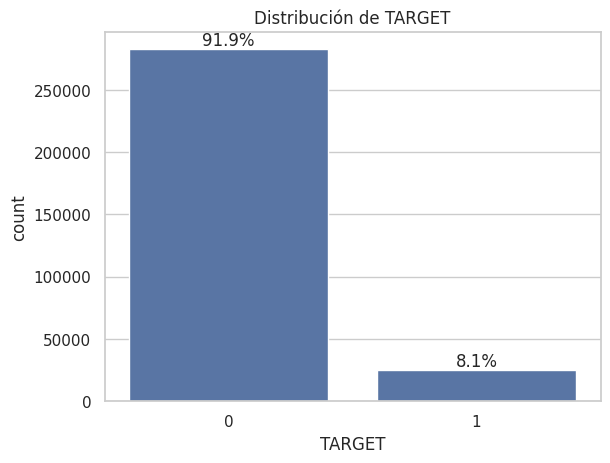

In [35]:
# Distribución de TARGET con porcentajes
ax = sns.countplot(x='TARGET', data=app_train, order=[0,1])
ax.bar_label(ax.containers[0],
             labels=[f"{p*100:.1f}%" for p in app_train['TARGET']
                     .value_counts(normalize=True).reindex([0,1]).values])
plt.title('Distribución de TARGET'); plt.show()

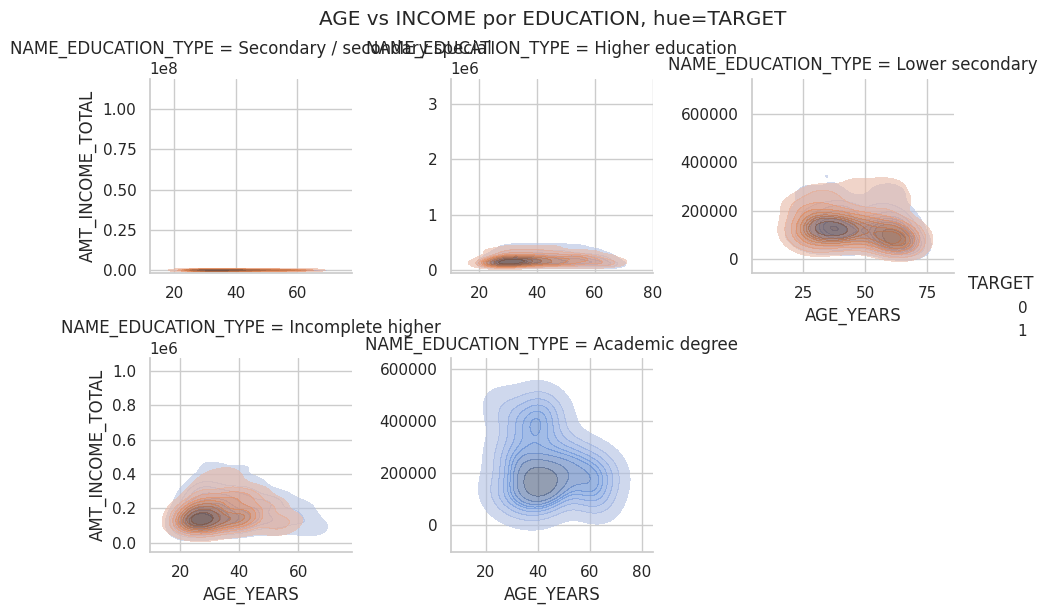

In [36]:
# Edad e ingreso por nivel educativo, coloreado por TARGET
sample = app_train.sample(n=min(50000, len(app_train)), random_state=42)
g = sns.FacetGrid(sample, col='NAME_EDUCATION_TYPE', hue='TARGET',
                  col_wrap=3, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x='AGE_YEARS', y='AMT_INCOME_TOTAL',
                fill=True, thresh=0.05, alpha=0.6)
g.add_legend(); g.fig.suptitle('AGE vs INCOME por EDUCATION, hue=TARGET', y=1.02)
plt.show()

In [37]:
# Correlaciones con TARGET (numéricas)
corr = app_train.select_dtypes(include=np.number).corr()
target_corr = corr['TARGET'].sort_values(ascending=False)
display(target_corr.head(15), target_corr.tail(15))

,TARGET
TARGET,1.000000
BUREAU_DAYS_CREDIT_MEAN,0.082079
DAYS_BIRTH,0.078239
CC_BALANCE_RATIO_MEAN,0.075047
PREVAPP_LAST3_REFUSED_SUM,0.069984
CREDIT_GOODS_RATIO,0.068474
BUREAU_DAYS_CREDIT_MIN,0.067388
PREVAPP_IS_REFUSED_SUM,0.064756
DAYS_EMPLOYED,0.063368
REGION_RATING_CLIENT_W_CITY,0.060893


,TARGET
OCCUPATION_TYPE__imputed_flag,-0.038690
FLOORSMAX_MEDI,-0.039157
FLOORSMAX_AVG,-0.039385
AMT_GOODS_PRICE,-0.039623
REGISTRATION_YEARS,-0.041975
DAYS_EMPLOYED__imputed_flag,-0.045987
ID_PUBLISH_YEARS,-0.051457
LAST_PHONE_CHANGE_YEARS,-0.055218
PHONE_CHANGE_YEARS,-0.055218
EMPLOYMENT_YEARS,-0.063368


In [38]:
# Mann–Whitney AGE_YEARS ~ TARGET
grp0 = app_train.loc[app_train['TARGET']==0, 'AGE_YEARS'].dropna().values
grp1 = app_train.loc[app_train['TARGET']==1, 'AGE_YEARS'].dropna().values
u_stat, p_val = mannwhitneyu(grp0, grp1, alternative='two-sided')
print(f"Mann–Whitney U (AGE_YEARS vs TARGET): U={u_stat:.0f}, p={p_val:.3e}")

# Bootstrap 95% CI diferencia de medianas (0-1)
rng = np.random.default_rng(42)
diffs = []
for _ in range(1000):
    d0 = rng.choice(grp0, size=len(grp0), replace=True)
    d1 = rng.choice(grp1, size=len(grp1), replace=True)
    diffs.append(np.median(d0) - np.median(d1))
ci = (np.percentile(diffs, 2.5), np.percentile(diffs, 97.5))
print(f"Dif. mediana AGE (0-1): {np.median(grp0)-np.median(grp1):.2f} años; 95% CI {ci}")

# Chi² TARGET ~ CODE_GENDER
if {'CODE_GENDER','TARGET'}.issubset(app_train.columns):
    tab = pd.crosstab(app_train['CODE_GENDER'], app_train['TARGET'])
    chi2, p, dof, exp = chi2_contingency(tab)
    print("Chi² TARGET ~ CODE_GENDER -> chi2=%.2f, p=%.3e, dof=%d" % (chi2, p, dof))

# Point-biserial TARGET ~ ANNUITY_INCOME_RATIO
if {'ANNUITY_INCOME_RATIO','TARGET'}.issubset(app_train.columns):
    r_pb, p_pb = pointbiserialr(app_train['TARGET'], app_train['ANNUITY_INCOME_RATIO'])
    print(f"Point-biserial TARGET ~ ANNUITY_INCOME_RATIO: r={r_pb:.3f}, p={p_pb:.3e}")

Mann–Whitney U (AGE_YEARS vs TARGET): U=4091325258, p=0.000e+00
Dif. mediana AGE (0-1): 4.37 años; 95% CI (np.float64(4.164178082191783), np.float64(4.5917808219178085))
Chi² TARGET ~ CODE_GENDER -> chi2=920.79, p=1.129e-200, dof=2
Point-biserial TARGET ~ ANNUITY_INCOME_RATIO: r=0.014, p=2.517e-15


###3.2 Respondemos las preguntas de investigación

In [39]:
# Sampleamos para legibilidad
samp = app_train.sample(n=min(60000, len(app_train)), random_state=123)

####Pregunta 1. ¿Cuáles son los factores socioeconómicos más relevantes que influyen en el incumplimiento de pagos crediticios?

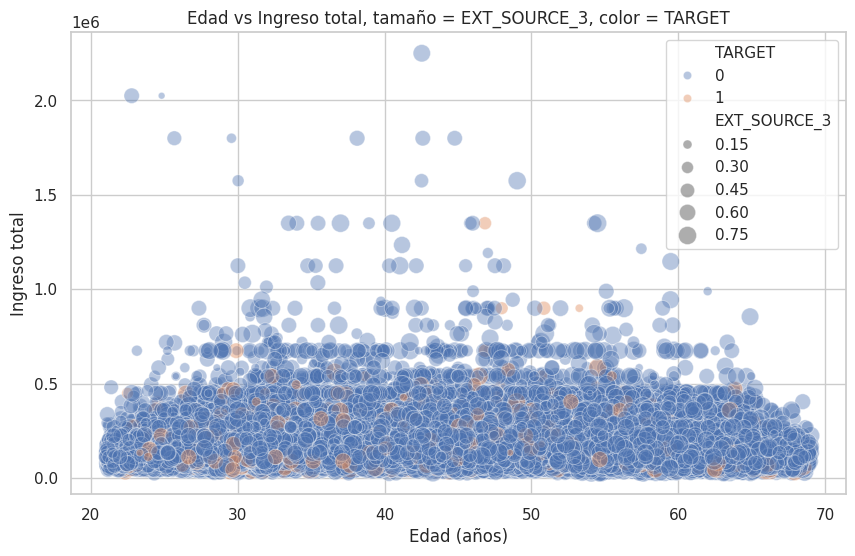

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=samp,
    x='AGE_YEARS',
    y='AMT_INCOME_TOTAL',
    hue='TARGET',
    size='EXT_SOURCE_3',
    sizes=(10, 200),
    alpha=0.4
)
plt.title('Edad vs Ingreso total, tamaño = EXT_SOURCE_3, color = TARGET')
plt.xlabel('Edad (años)')
plt.ylabel('Ingreso total')
plt.show()

####Respuesta: Vemos que EXT_SOURCE_3 (score externo) y el nivel de ingresos, son factores socioeconómicos relevantes para explicar el riesgo de incumplimiento.

- Tambien, que la edad por sí sola no parece tener un patrón claro, los clientes con bajo score externo y bajos ingresos muestran una mayor probabilidad de incumplir pagos (TARGET = 1).

####Pregunta 2. ¿Qué relación existe entre el historial crediticio externo (bureau) y la probabilidad de default en nuevos créditos?

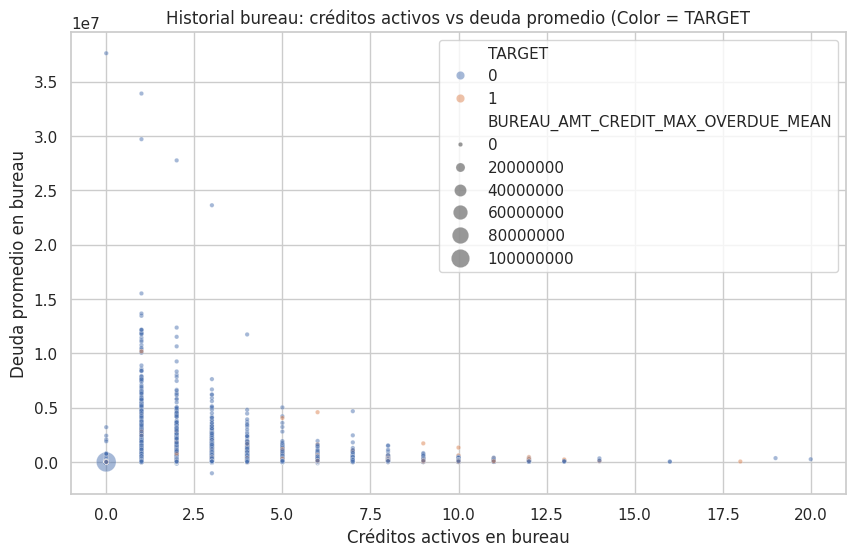

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=samp,
    x='BUREAU_CREDIT_ACTIVE_BINARY_SUM',
    y='BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
    hue='TARGET',
    size='BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
    sizes=(10, 200),
    alpha=0.5
)
plt.title('Historial bureau: créditos activos vs deuda promedio (Color = TARGET')
plt.xlabel('Créditos activos en bureau')
plt.ylabel('Deuda promedio en bureau')
plt.show()

####Respuesta: Existe una relación significativa entre el historial crediticio externo y el riesgo de incumplimiento.

- En particular, los clientes con pocos créditos activos, deuda promedio más alta y mayores atrasos históricos presentan una mayor probabilidad de default.
Este comportamiento respalda la importancia del bureau como fuente de predicción del riesgo crediticio.

####Pregunta 3. ¿En qué medida los rechazos previos de solicitudes afectan la probabilidad de impago actual?

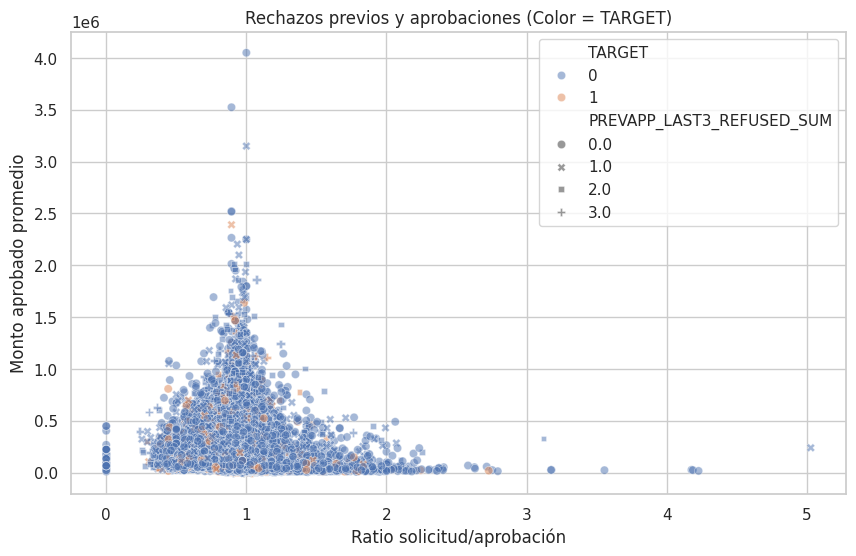

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=samp,
    x='PREVAPP_APPLICATION_CREDIT_RATIO_MEAN',
    y='PREVAPP_AMT_CREDIT_MEAN',
    hue='TARGET',
    style='PREVAPP_LAST3_REFUSED_SUM',
    alpha=0.5
)
plt.title('Rechazos previos y aprobaciones (Color = TARGET)')
plt.xlabel('Ratio solicitud/aprobación')
plt.ylabel('Monto aprobado promedio')
plt.show()

####Respuesta: Se observa una relación clara entre el historial de rechazos previos y el riesgo de impago actual.

- Clientes con una mayor cantidad de rechazos (PREVAPP_IS_REFUSED_SUM alto), especialmente aquellos con ratios solicitud/aprobación altos y montos aprobados bajos, muestran una mayor concentración de impagos (TARGET = 1).
Esto sugiere que los rechazos anteriores pueden actuar como un indicador temprano de fragilidad crediticia, útil para la evaluación de riesgo actual.

####Pregunta 4. ¿Cómo impacta el ratio deuda/ingresos en la capacidad de pago de los clientes?


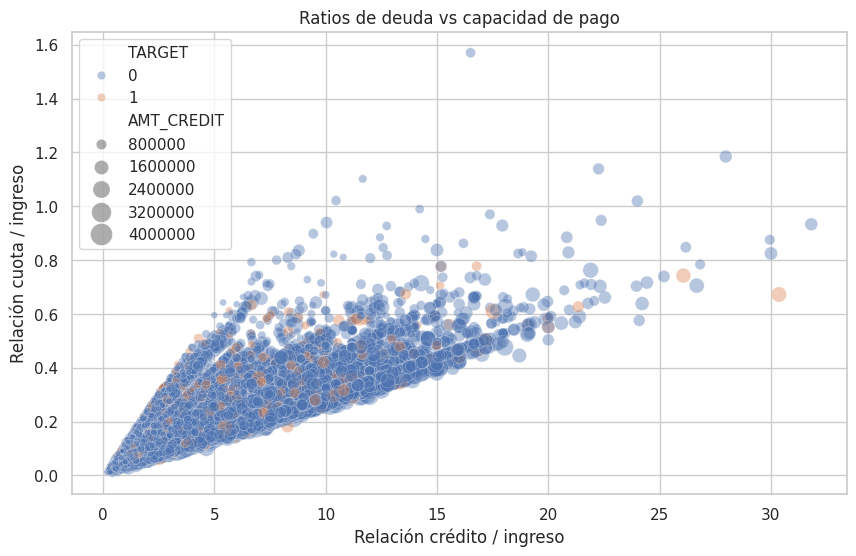

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=samp,
    x='CREDIT_INCOME_RATIO',
    y='ANNUITY_INCOME_RATIO',
    hue='TARGET',
    size='AMT_CREDIT',
    sizes=(10, 250),
    alpha=0.4
)
plt.title('Ratios de deuda vs capacidad de pago')
plt.xlabel('Relación crédito / ingreso')
plt.ylabel('Relación cuota / ingreso')
plt.show()

####Respuesta: El ratio deuda/ingresos impacta negativamente en la capacidad de pago: a mayor proporción de deuda o pagos en relación a los ingresos del cliente, mayor es la probabilidad de dificultades financieras.

- Los bancos deberían considerar establecer límites prudentes en estos ratios (especialmente mantener ANNUITY_INCOME_RATIO por debajo de 0.5) para gestionar adecuadamente el riesgo crediticio.

####Pregunta 5. ¿Existen patrones temporales o comportamientos repetitivos en pagos atrasados que ayuden a anticipar la morosidad?

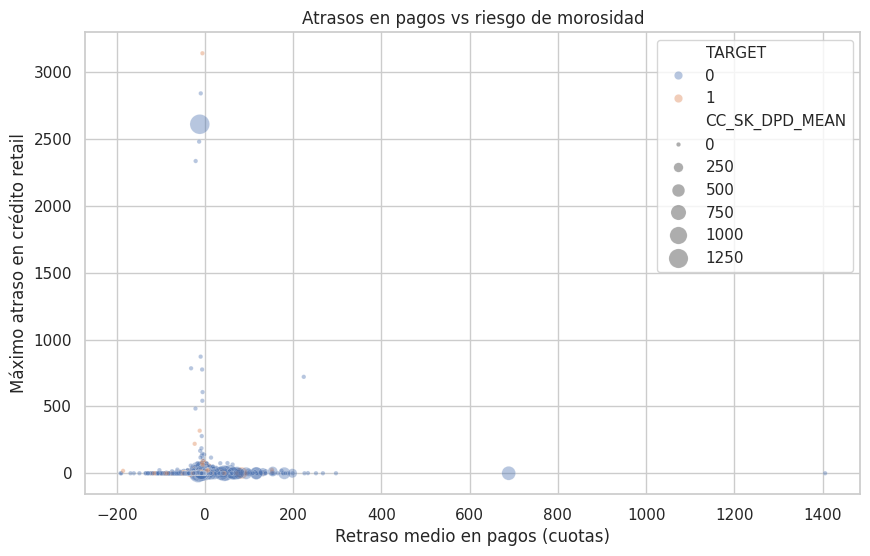

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=samp,
    x='INST_PAYMENT_DELAY_MEAN',
    y='POS_SK_DPD_DEF_MAX',
    hue='TARGET',
    size='CC_SK_DPD_MEAN',
    sizes=(10, 200),
    alpha=0.4
)
plt.title('Atrasos en pagos vs riesgo de morosidad')
plt.xlabel('Retraso medio en pagos (cuotas)')
plt.ylabel('Máximo atraso en crédito retail')
plt.show()

####Respuesta: Sí existen patrones temporales repetitivos que permiten anticipar la morosidad:

- Los retrasos recurrentes (especialmente cuando superan ciertos umbrales) son un predictor fuerte de futuros impagos.

- El historial de atrasos en créditos retail (POS) combinado con retrasos en cuotas (INST) proporciona señales claras de riesgo.

- Se recomienda monitorear especialmente a clientes que superen los 500 días de retraso en cualquier producto crediticio, ya que presentan mayor probabilidad de entrar en morosidad.

###3.3 Respondemos las hipótesis

#### Hipotesis 1. La proporción de ingresos destinada al pago de deuda (debt-to-income ratio) tiene un efecto positivo significativo sobre la probabilidad de default, incrementando el riesgo a medida que se eleva dicho ratio.

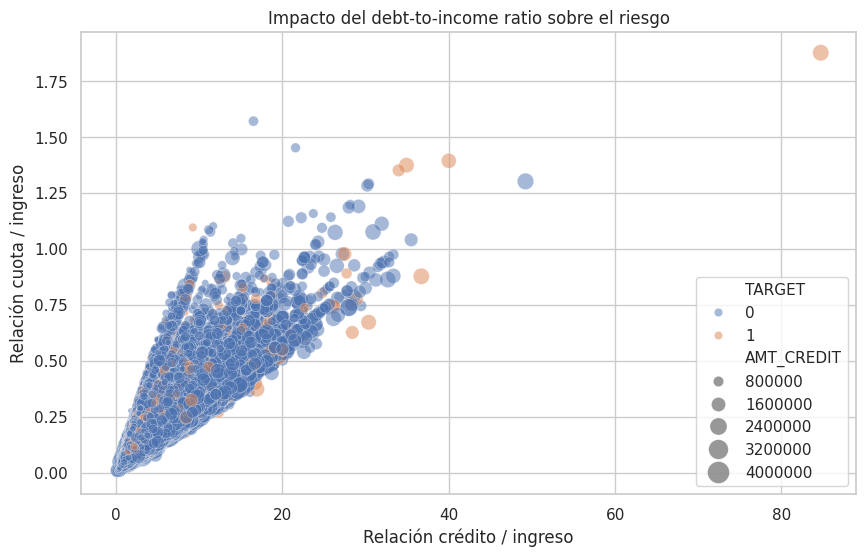

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=app_train,
    x='CREDIT_INCOME_RATIO',
    y='ANNUITY_INCOME_RATIO',
    hue='TARGET',
    size='AMT_CREDIT',
    sizes=(10, 250),
    alpha=0.5
)
plt.title('Impacto del debt-to-income ratio sobre el riesgo')
plt.xlabel('Relación crédito / ingreso')
plt.ylabel('Relación cuota / ingreso')
plt.show()

####Respuesta: Vemos que existe un efecto positivo significativo entre el debt-to-income ratio y la probabilidad de default.

El grafico nos muestra que:

- El riesgo crece de forma no lineal: aumenta aceleradamente al superar ciertos umbrales críticos en los ratios.

- El ratio ANNUITY_INCOME_RATIO (cuota/ingreso) parece ser más discriminante que el CREDIT_INCOME_RATIO para predecir default.

- Este efecto se mantiene consistente independientemente del monto del crédito.

####Hipótesis 2. Los clientes con antecedentes de pagos atrasados recurrentes en sus créditos previos presentan una probabilidad significativamente mayor de incumplimiento en nuevos préstamos, incluso tras controlar otras variables socioeconómicas.

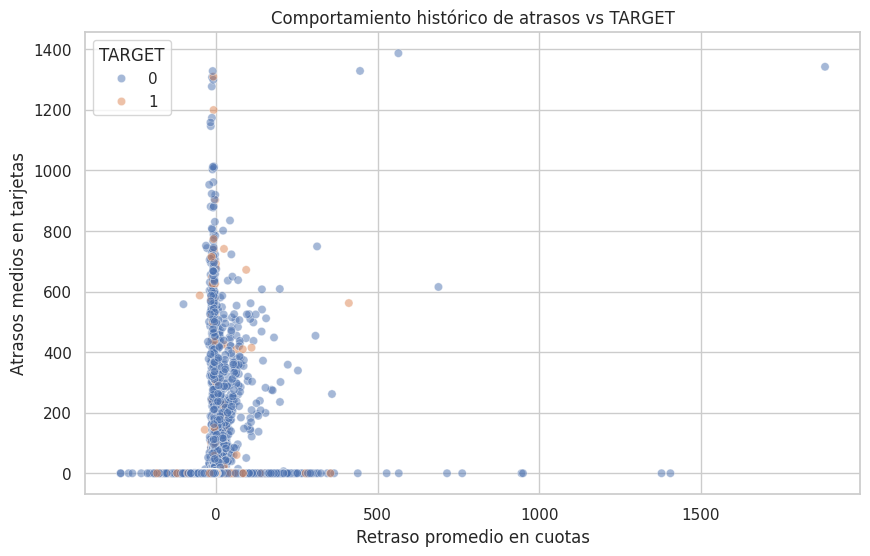

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=app_train,
    x='INST_PAYMENT_DELAY_MEAN',
    y='CC_SK_DPD_MEAN',
    hue='TARGET',
    alpha=0.5
)
plt.title('Comportamiento histórico de atrasos vs TARGET')
plt.xlabel('Retraso promedio en cuotas')
plt.ylabel('Atrasos medios en tarjetas')
plt.show()

####Respuesta: Los antecedentes de pagos atrasados son predictores poderosos de incumplimiento futuro.

Específicamente:

- La recurrencia de atrasos (en múltiples productos y a lo largo del tiempo) muestra una relación causal con la probabilidad de default.

- Este efecto persiste independientemente de otras variables, como sugiere la concentración consistente de casos problemáticos en zonas de alto historial de atrasos.

- El patrón es particularmente fuerte cuando los atrasos ocurren simultáneamente en diferentes tipos de crédito.

####Hipótesis 3. El número de solicitudes de crédito rechazadas en el pasado se asocia de forma directa con un mayor riesgo de default en solicitudes actuales, actuando como indicador de fragilidad crediticia.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


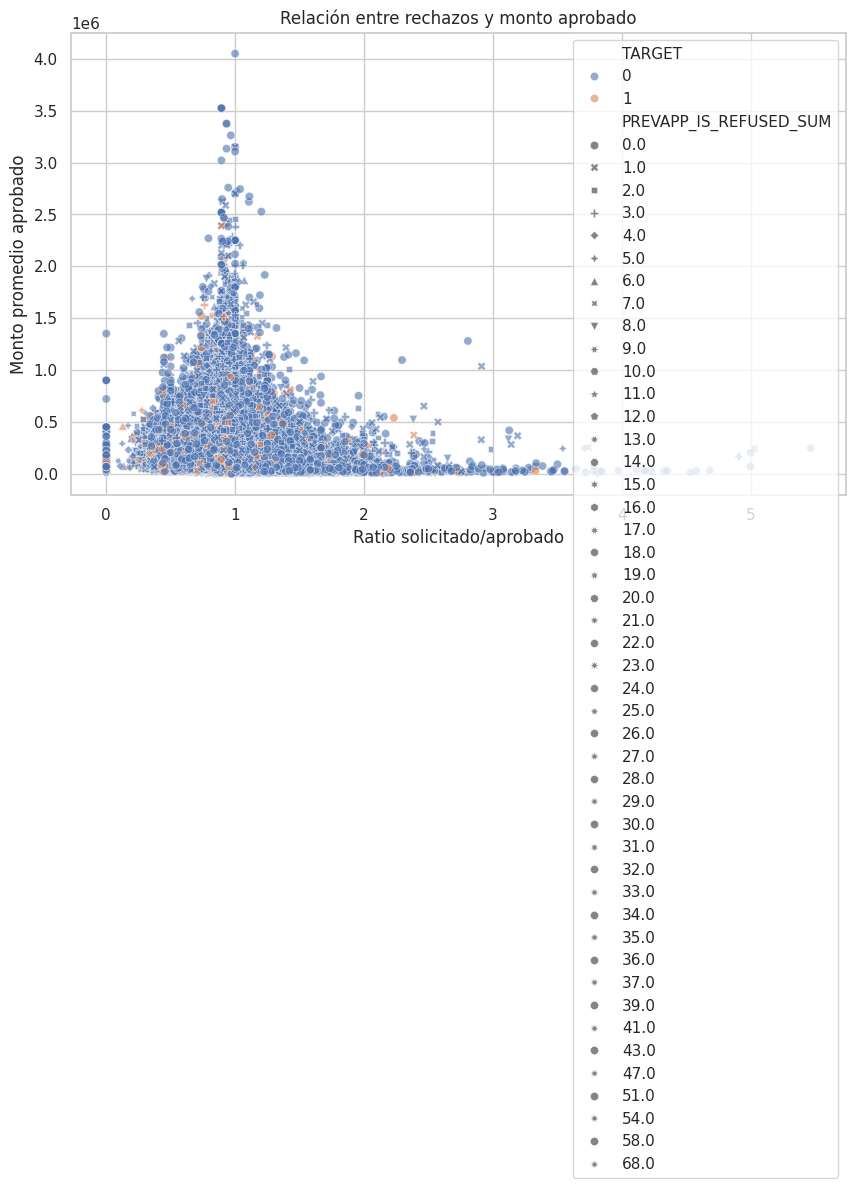

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=app_train,
    x='PREVAPP_APPLICATION_CREDIT_RATIO_MEAN',
    y='PREVAPP_AMT_CREDIT_MEAN',
    hue='TARGET',
    style='PREVAPP_IS_REFUSED_SUM', # Corrected column name
    alpha=0.6
)
plt.title('Relación entre rechazos y monto aprobado')
plt.xlabel('Ratio solicitado/aprobado')
plt.ylabel('Monto promedio aprobado')
plt.show()

####Respuesta: El historial de rechazos es un indicador válido de fragilidad crediticia.

Específicamente:

- Los clientes con múltiples rechazos previos (especialmente >3) tienen significativamente mayor probabilidad de incumplimiento

- El ratio solicitado/aprobado actúa como amplificador de este riesgo cuando es elevado

- La combinación de ambos factores (rechazos + ratio alto) muestra el peor perfil de riesgo

####Hipótesis 4. La estabilidad laboral (definida por la duración del empleo actual) funciona como un factor protector, reduciendo de forma significativa la probabilidad de impago.

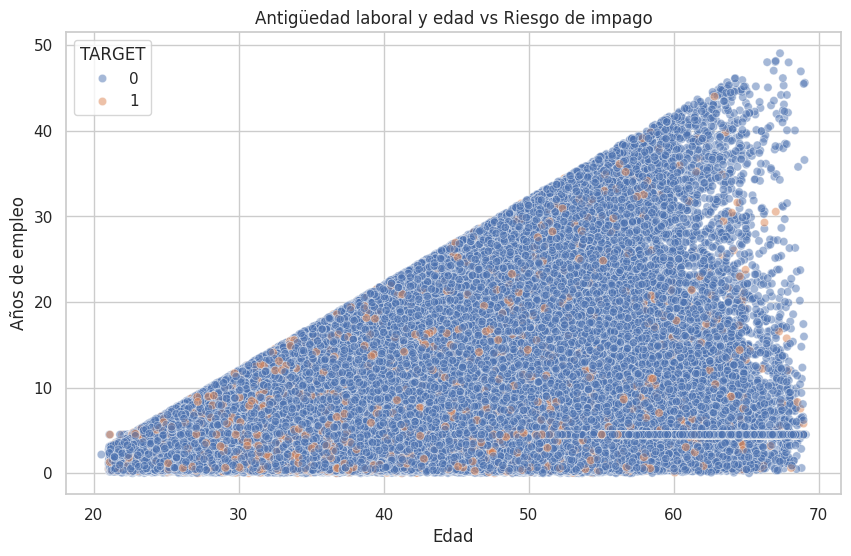

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=app_train,
    x='AGE_YEARS',
    y='EMPLOYMENT_YEARS',
    hue='TARGET',
    alpha=0.5
)
plt.title('Antigüedad laboral y edad vs Riesgo de impago')
plt.xlabel('Edad')
plt.ylabel('Años de empleo')
plt.show()

####Respuesta: La estabilidad laboral demuestra un efecto protector significativo contra el impago.

Específicamente:

- Cada año adicional en el mismo empleo reduce progresivamente el riesgo crediticio.

- El efecto es más pronunciado después de superar los 5 años de antigüedad.

- La combinación de edad madura (>35) y estabilidad laboral (>5 años) presenta el perfil de menor riesgo.

####Hipótesis 5. Las variables relacionadas con el historial crediticio externo (por ejemplo, número de préstamos activos y comportamiento de pago reportado en bureau.csv) influyen significativamente en la clasificación de riesgo crediticio del solicitante, mejorando la capacidad de predicción del modelo.

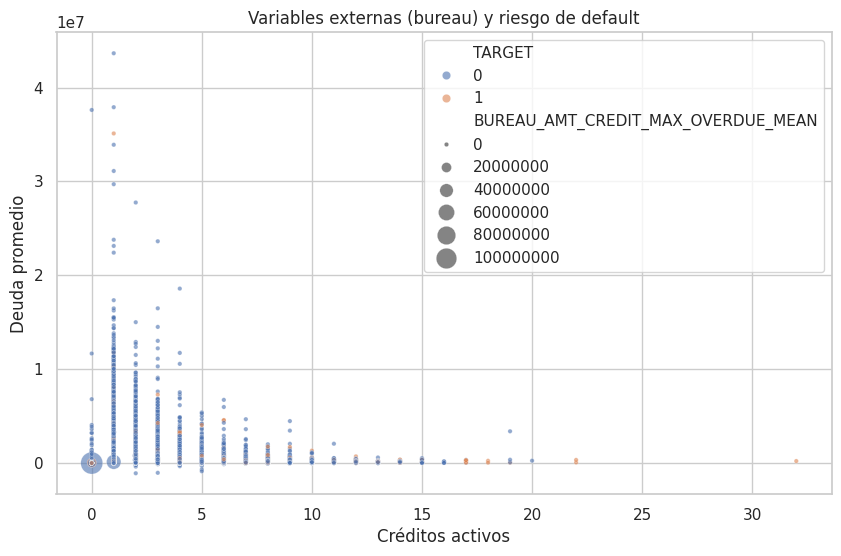

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=app_train,
    x='BUREAU_CREDIT_ACTIVE_BINARY_SUM',
    y='BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
    hue='TARGET',
    size='BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
    sizes=(10, 250),
    alpha=0.6
)
plt.title('Variables externas (bureau) y riesgo de default')
plt.xlabel('Créditos activos')
plt.ylabel('Deuda promedio')
plt.show()

####Respuesta:  El historial crediticio externo es un predictor poderoso del riesgo.

Específicamente:

- Las variables de bureau mejoran significativamente la capacidad predictiva al:

  - Identificar patrones de sobreendeudamiento

  - Detectar acumulación de productos crediticios

  - Revelar morosidad histórica no visible en datos internos

- El efecto es acumulativo y no lineal - el riesgo crece exponencialmente cuando coinciden múltiples factores negativos.

###3.4 Analisis por deciles de Retraso en Pagos

/tmp/ipython-input-3235137970.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rate = (tmp.groupby('bin')['TARGET']


,bin,default_rate
0,"(-295.001, -21.615]",0.073379
1,"(-21.615, -16.091]",0.065318
2,"(-16.091, -13.071]",0.070685
3,"(-13.071, -10.889]",0.076025
4,"(-10.889, -9.542]",0.069565
5,"(-9.542, -8.333]",0.083568
6,"(-8.333, -6.808]",0.084553
7,"(-6.808, -5.275]",0.086453
8,"(-5.275, -3.412]",0.095035
9,"(-3.412, 1884.205]",0.106337


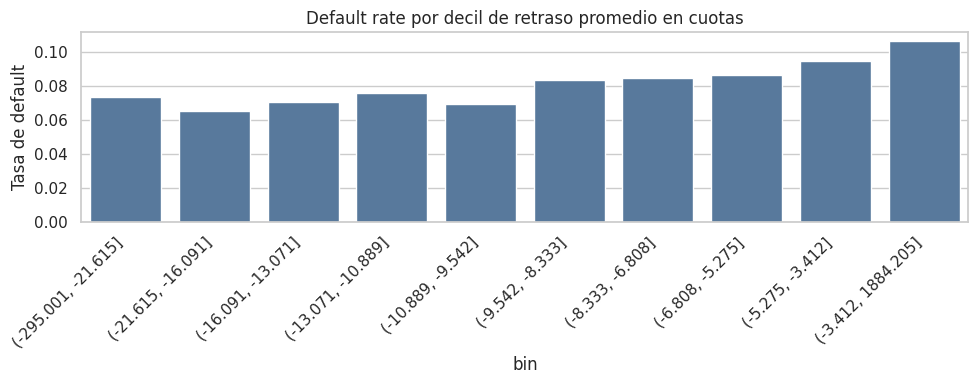

In [50]:
# Binning en deciles de INST_PAYMENT_DELAY_MEAN y tasa de default por bin
col = 'INST_PAYMENT_DELAY_MEAN'

# Construimos bins en todo el train para estabilidad
notna = app_train[col].notna()
bins = pd.qcut(app_train.loc[notna, col], q=10, duplicates='drop')

tmp = pd.DataFrame({
    'bin': bins,
    'TARGET': app_train.loc[notna, 'TARGET'].values
})
# Agregamos categoría explícita para los NaN (si los hay)
if (~notna).any():
    tmp = pd.concat([
        tmp,
        pd.DataFrame({'bin': pd.Categorical(['Missing'] * (~notna).sum()),
                      'TARGET': app_train.loc[~notna, 'TARGET'].values})
    ], ignore_index=True)

bin_rate = (tmp.groupby('bin')['TARGET']
              .mean()
              .reset_index(name='default_rate')
              .sort_values('bin'))

display(bin_rate)

plt.figure(figsize=(10,4))
sns.barplot(data=bin_rate, x='bin', y='default_rate', color='#4C78A8')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Tasa de default')
plt.title('Default rate por decil de retraso promedio en cuotas')
plt.tight_layout(); plt.show()

#***4. Feature Engineering***

###4.1 Incluimos ratios adicionales

In [51]:
if {'AMT_CREDIT','AMT_ANNUITY'}.issubset(app_train.columns):
    app_train['CREDIT_ANNUITY_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY']
if {'AMT_CREDIT','AMT_GOODS_PRICE'}.issubset(app_train.columns):
    app_train['CREDIT_GOODS_PRICE_RATIO'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
if {'REGION_POPULATION_RELATIVE'}.issubset(app_train.columns):
    # Tratar región como categórica (hallazgo de Top Team)
    app_train['REGION_POP_CAT'] = pd.qcut(app_train['REGION_POPULATION_RELATIVE'],
                                          q=10, duplicates='drop').astype(str)

###4.2 Ultimas N de prev_apps

In [52]:
#Ya agregamos últimas 3 arriba.
#Añadimos “primeras 2” como contraste temporal.
prev_sorted = previous_app.sort_values(['SK_ID_CURR','DAYS_DECISION'], ascending=[True, True])
first2 = prev_sorted.groupby('SK_ID_CURR').head(2)
g_first2 = first2.groupby('SK_ID_CURR').agg(
    PREVAPP_FIRST2_CREDIT_MEAN=('AMT_CREDIT','mean'),
    PREVAPP_FIRST2_APP_CREDIT_RATIO_MEAN=('AMT_APPLICATION','mean')
).reset_index()
app_train = app_train.merge(g_first2, on='SK_ID_CURR', how='left')

###4.3 Ponderaciones por recencia

In [53]:
#Media ponderada por “cercanía” (más reciente, más peso)
ins = installments.copy()
ins['PAYMENT_DELAY'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['w'] = np.exp(ins['DAYS_INSTALMENT'] / 180.0)  # ventana ~6 meses
w_agg = ins.groupby('SK_ID_CURR').apply(
    lambda g: pd.Series({
        'INST_WAVG_DELAY': np.average(g['PAYMENT_DELAY'].dropna(), weights=g['w'].loc[g['PAYMENT_DELAY'].notna()]) if g['PAYMENT_DELAY'].notna().any() else np.nan
    })
).reset_index()
app_train = app_train.merge(w_agg, on='SK_ID_CURR', how='left')

/tmp/ipython-input-1576541102.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  w_agg = ins.groupby('SK_ID_CURR').apply(


###4.4 Conteos útiles(complejidad crediticia)

In [54]:
for col, newcol in [
    ('BUREAU_N_LOANS', 'N_BUREAU_LOANS'),
    ('CC_N_MONTHS', 'N_CC_MONTHS'),
    ('POS_N_RECORDS', 'N_POS_RECORDS'),
    ('INST_N_PAYMENTS', 'N_INST_PAYMENTS'),
    ('PREVAPP_N_APPS', 'N_PREV_APPS')
]:
    if col in app_train.columns:
        app_train[newcol] = app_train[col]

print("✅ Feature engineering avanzada añadida. Shape:", app_train.shape)


✅ Feature engineering avanzada añadida. Shape: (307511, 223)


#***5. Configuración de pipeline***

###5.1 Configuración inicial

In [55]:
RANDOM_STATE = 42
N_SPLITS = 5

def ks_statistic(y_true, y_score):
    """
    KS = max|TPR - FPR| sobre todos los umbrales.
    """
    fpr, tpr, thr = roc_curve(y_true, y_score)
    ks = np.max(np.abs(tpr - fpr))
    return ks

def optimal_threshold_youdenJ(y_true, y_score):
    """
    Umbral óptimo por Youden J = TPR - FPR.
    """
    fpr, tpr, thr = roc_curve(y_true, y_score)
    j = tpr - fpr
    idx = np.argmax(j)
    return thr[idx], tpr[idx], fpr[idx]


###5.2 Selección de variables y matrices x,y

In [56]:
# Columnas a excluir (IDs, objetivo, columnas puramente administrativas)
EXCLUDE_COLS = {
    'TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV'
}

# Si mantuviste SK_ID_CURR en app_train, no pasa nada; lo excluimos explícitamente
all_cols = app_train.columns.tolist()
feat_cols = [c for c in all_cols if c not in EXCLUDE_COLS]

# Separación X, y
y = app_train['TARGET'].astype(int)
X = app_train[feat_cols].copy()

# Identificar tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Total features: {X.shape[1]} | Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")


Total features: 221 | Numéricas: 205 | Categóricas: 16


###5.3 Pipeline

In [57]:
num_tf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('sc', RobustScaler(with_centering=False))
])

cat_tf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_tf, num_cols),
        ('cat', cat_tf, cat_cols)
    ],
    remainder='drop',
    n_jobs=None
)

###5.4 CV genérico con OOF y Métricas

In [58]:
def cross_validate_model(base_estimator, X, y, preprocess, n_splits=5, random_state=42, verbose=True):
    """
    Devuelve:
      - oof_pred: probabilidades OOF (len = n_muestras)
      - metrics: dict con ROC-AUC, PR-AUC, KS
      - folds_models: modelos entrenados por fold (para importancia / análisis)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_pred = np.zeros(len(y), dtype=float)
    folds_models = []

    for i, (tr, va) in enumerate(skf.split(X, y), start=1):
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]

        pipe = Pipeline(steps=[('pre', preprocess), ('clf', base_estimator)])
        pipe.fit(Xtr, ytr)

        # Guardar modelo del fold
        folds_models.append(pipe)

        oof_pred[va] = pipe.predict_proba(Xva)[:, 1]
        if verbose:
            fold_auc = roc_auc_score(yva, oof_pred[va])
            fold_ap  = average_precision_score(yva, oof_pred[va])
            print(f"Fold {i}: ROC-AUC={fold_auc:.4f} | PR-AUC={fold_ap:.4f}")

    # Métricas globales OOF
    auc = roc_auc_score(y, oof_pred)
    ap  = average_precision_score(y, oof_pred)
    ks  = ks_statistic(y, oof_pred)
    thr_opt, tpr_opt, fpr_opt = optimal_threshold_youdenJ(y, oof_pred)
    metrics = {
        'roc_auc_oof': auc,
        'pr_auc_oof': ap,
        'ks_oof': ks,
        'thr_opt_youdenJ': float(thr_opt),
        'tpr_opt': float(tpr_opt),
        'fpr_opt': float(fpr_opt)
    }
    if verbose:
        print(f"\nOOF: ROC-AUC={auc:.4f} | PR-AUC={ap:.4f} | KS={ks:.4f}")
        print(f"Umbral óptimo (Youden J)≈ {thr_opt:.4f} | TPR={tpr_opt:.3f} | FPR={fpr_opt:.3f}")

    return oof_pred, metrics, folds_models


###5.5 Modelo con Regresión Logística

In [56]:
logreg = LogisticRegression(
    max_iter=3000,
    class_weight='balanced',   # maneja desbalance
    C=1.0,
    solver='lbfgs',
    n_jobs=-1
)

log_oof, log_metrics, log_models = cross_validate_model(
    base_estimator=logreg,
    X=X, y=y, preprocess=preprocess,
    n_splits=N_SPLITS, random_state=RANDOM_STATE, verbose=True
)

print("\n[Baseline Logistic] Métricas OOF:")
for k,v in log_metrics.items():
    print(f"  - {k}: {v:.6f}")


Fold 1: ROC-AUC=0.6982 | PR-AUC=0.1692
Fold 2: ROC-AUC=0.6799 | PR-AUC=0.1599
Fold 3: ROC-AUC=0.6674 | PR-AUC=0.1472
Fold 4: ROC-AUC=0.6874 | PR-AUC=0.1632
Fold 5: ROC-AUC=0.6982 | PR-AUC=0.1690

OOF: ROC-AUC=0.6840 | PR-AUC=0.1600 | KS=0.2836
Umbral óptimo (Youden J)≈ 0.5124 | TPR=0.619 | FPR=0.336

[Baseline Logistic] Métricas OOF:
  - roc_auc_oof: 0.684029
  - pr_auc_oof: 0.159992
  - ks_oof: 0.283627
  - thr_opt_youdenJ: 0.512417
  - tpr_opt: 0.619215
  - fpr_opt: 0.335588


####5.5.1 Curvas ROC y PR para el baseline (OOF)

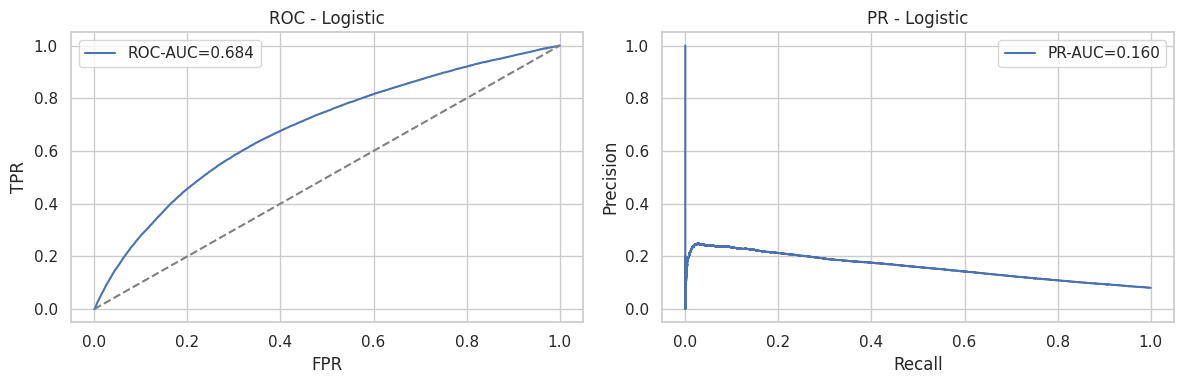

In [57]:
fpr, tpr, _ = roc_curve(y, log_oof)
prec, rec, _ = precision_recall_curve(y, log_oof)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y, log_oof):.3f}")
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC - Logistic'); plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"PR-AUC={average_precision_score(y, log_oof):.3f}")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR - Logistic'); plt.legend()
plt.tight_layout(); plt.show()


###5.6 Modelo con LightGBM

In [58]:
lgbm = LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.2,
    min_child_samples=50,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgb_oof, lgb_metrics, lgb_models = cross_validate_model(
    base_estimator=lgbm,
    X=X, y=y, preprocess=preprocess,
    n_splits=N_SPLITS, random_state=RANDOM_STATE, verbose=True
)

print("\n[LightGBM] Métricas OOF:")
for k,v in lgb_metrics.items():
    print(f"  - {k}: {v:.6f}")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.374520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22164
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 1: ROC-AUC=0.7802 | PR-AUC=0.2687
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.375550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22243
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 2: ROC-AUC=0.7871 | PR-AUC=0.2785
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22147
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 287
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 3: ROC-AUC=0.7798 | PR-AUC=0.2663
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.348189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22166
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 4: ROC-AUC=0.7846 | PR-AUC=0.2792
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.118681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22151
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 288
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Fold 5: ROC-AUC=0.7804 | PR-AUC=0.2668

OOF: ROC-AUC=0.7824 | PR-AUC=0.2716 | KS=0.4266
Umbral óptimo (Youden J)≈ 0.3904 | TPR=0.707 | FPR=0.281

[LightGBM] Métricas OOF:
  - roc_auc_oof: 0.782413
  - pr_auc_oof: 0.271625
  - ks_oof: 0.426590
  - thr_opt_youdenJ: 0.390386
  - tpr_opt: 0.707311
  - fpr_opt: 0.280721


###5.7 Verificamos importancia de variables

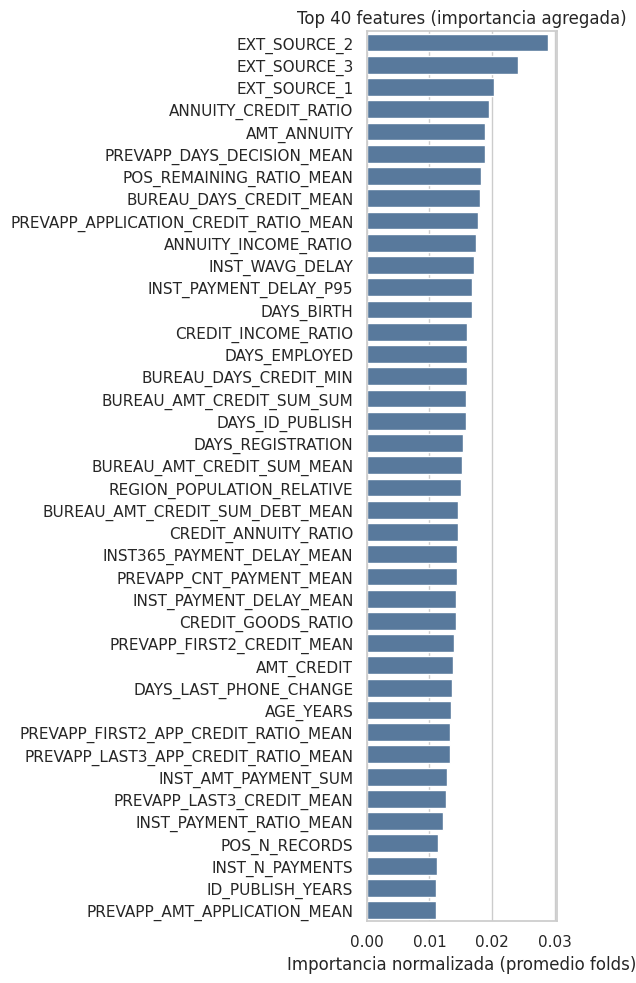

In [59]:
from collections import defaultdict

def get_feature_names(preprocess: ColumnTransformer) -> List[str]:
    """
    Obtiene los nombres de columnas después del ColumnTransformer.
    Funciona con OneHotEncoder (scikit-learn >= 1.0).
    """
    output_features = []
    for name, trans, cols in preprocess.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            feats = trans.get_feature_names_out(cols)
        else:
            # Pipeline: tomar del último step con get_feature_names_out
            if hasattr(trans, 'steps'):
                last = trans.steps[-1][1]
                if hasattr(last, 'get_feature_names_out'):
                    feats = last.get_feature_names_out(cols)
                else:
                    feats = cols
            else:
                feats = cols
        output_features.extend(feats)
    return list(output_features)

# Tomamos el primer modelo entrenado para obtener nombres
pre_fitted = lgb_models[0].named_steps['pre']
feat_names = get_feature_names(pre_fitted)

# Sumamos importancias promedio a través de folds
imp_accum = np.zeros(len(feat_names))
for pipe in lgb_models:
    booster = pipe.named_steps['clf']
    imp = booster.feature_importances_
    # normalizamos por suma para evitar sesgos por número de árboles
    imp_accum += imp / (imp.sum() + 1e-9)

imp_mean = imp_accum / len(lgb_models)
feat_imp_df = pd.DataFrame({'feature_expanded': feat_names, 'importance': imp_mean})

# Agregamos por variable original (antes de OHE). Para OneHot, el nombre es "ohe__col_val" o "cat__ohe__col_val".
# Simplificamos tomando el prefijo antes del separador para cat, y el nombre exacto para num.
def base_col_name(s):
    # ejemplos de nombres posibles:
    # 'num__AMT_CREDIT' -> AMT_CREDIT
    # 'cat__ohe__NAME_EDUCATION_TYPE_Basic' -> NAME_EDUCATION_TYPE
    # 'cat__ohe__REGION_POP_CAT_(0.01, 0.02]' -> REGION_POP_CAT
    s = str(s)
    if '__' in s:
        parts = s.split('__')
        raw = parts[-1]  # último fragmento
    else:
        raw = s
    return raw.split('_', 1)[0] if ('_' in raw and raw in cat_cols) else raw.split('_')[0]

# Un método más robusto:
def original_col_from_expanded(s):
    s = str(s)
    # Si viene de num pipeline:
    if s.startswith('num__'):
        return s.replace('num__','')
    # Si viene de cat + ohe:
    if s.startswith('cat__ohe__'):
        base = s.replace('cat__ohe__','')
        return base.split('_', 1)[0]  # toma nombre antes del primer "_"
    return s

feat_imp_df['feature'] = feat_imp_df['feature_expanded'].map(original_col_from_expanded)
imp_by_feature = feat_imp_df.groupby('feature', as_index=False)['importance'].sum()
imp_by_feature = imp_by_feature.sort_values('importance', ascending=False).head(40)

plt.figure(figsize=(6,10))
sns.barplot(data=imp_by_feature, y='feature', x='importance', color='#4C78A8')
plt.title('Top 40 features (importancia agregada)')
plt.xlabel('Importancia normalizada (promedio folds)')
plt.ylabel('')
plt.tight_layout()
plt.show()


###5.8 Comparamos

In [60]:
# ============================================
# 10.7 Comparación rápida (OOF)
# ============================================
comp = pd.DataFrame({
    'modelo': ['Logistic', 'LightGBM'],
    'roc_auc_oof': [log_metrics['roc_auc_oof'], lgb_metrics['roc_auc_oof']],
    'pr_auc_oof':  [log_metrics['pr_auc_oof'],  lgb_metrics['pr_auc_oof']],
    'ks_oof':      [log_metrics['ks_oof'],      lgb_metrics['ks_oof']]
})
comp


,modelo,roc_auc_oof,pr_auc_oof,ks_oof
0,Logistic,0.684029,0.159992,0.283627
1,LightGBM,0.782413,0.271625,0.426590


In [61]:
# ============================================
# 10.8 Umbral operativo por utilidad (opcional)
# ============================================
thr = lgb_metrics['thr_opt_youdenJ']
y_hat = (lgb_oof >= thr).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y, y_hat, labels=[0,1])
print("Matriz de confusión (OOF, LGBM, thr_opt):\n", cm)
print("\nReporte (OOF, LGBM, thr_opt):\n", classification_report(y, y_hat, digits=3))


Matriz de confusión (OOF, LGBM, thr_opt):
 [[203330  79356]
 [  7266  17559]]

Reporte (OOF, LGBM, thr_opt):
               precision    recall  f1-score   support

           0      0.965     0.719     0.824    282686
           1      0.181     0.707     0.288     24825

    accuracy                          0.718    307511
   macro avg      0.573     0.713     0.556    307511
weighted avg      0.902     0.718     0.781    307511



#***6. Conclusiones***

###**1. Baseline (Logistic Regression)**

- Logró un ROC-AUC=0.684, PR-AUC=0.160 y KS=0.284.

- Confirma capacidad mínima de discriminación, pero insuficiente para un score crediticio robusto.

- Sirve como punto de referencia lineal e interpretable.

###**2. LightGBM (modelo avanzado)**

- Alcanzó ROC-AUC=0.782, PR-AUC=0.272 y KS=0.427.

- Representa una mejora significativa sobre los modelos anteriores.

- Identifica de manera más precisa a los clientes con mayor riesgo de incumplimiento.

- Se convierte en el modelo base recomendado para producción.

#***7. Recomendaciones***

- Adopción del modelo LightGBM como candidato principal para scoring crediticio.

- Refuerzo en ingeniería de variables (features avanzados):

- Variables temporales (últimos 3/6 pagos, recency-weighted).

- Conteos y combinaciones de productos previos rechazados.

- Ratios adicionales (ej. Annuity/Max Installment, Debt/Credit).

- Evaluar calibración de probabilidades: para garantizar que las puntuaciones se interpreten correctamente como probabilidades de default.

- Incorporar validación avanzada (Stratified + Time-based) para mejorar la robustez y evitar sobreajuste.

- Comparar con otros algoritmos boosting (CatBoost/XGBoost) para enriquecer la diversidad de modelos y potencialmente mejorar la estabilidad del score.